**写在前面：**本节内容是 [Datawhale四月组队学习 - 集成学习（中）- CH4-集成学习之boosting -【Task9 Boosting思路与Adaboost算法】](https://github.com/datawhalechina/team-learning-data-mining/tree/master/EnsembleLearning) 的学习笔记，对应CH4的第1、2、3节，学习周期2天

## 库和数据

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import seaborn as sns

## Day1 Boosting
**参考资料**：
- [机器学习中最最好用的提升方法：Boosting 与 AdaBoost](https://zhuanlan.zhihu.com/p/57689719)
- [百度百科-Boosting](https://baike.baidu.com/item/Boosting/1403912?fr=aladdin)

&emsp;&emsp;我查阅了一些资料，发现Boosting往往和Bagging拿来对比。Bagging在前面已经了解到是一种减小方差的技术，适用于对数据分布敏感的模型；而通过本篇的学习，我了解到Boosting是一种降低偏差的技术。两者共同的地方是都通过训练一批弱学习器来集成为强学习器；不同之处在于：Bagging通过自主采样得到多份不同的数据集，在这些数据集上并行学习；Boosting通过改变训练数据集的概率分布(训练数据不同样本的权值)，针对不同概率分布的数据调用弱分类算法学习一系列的弱分类器，进行串行学习。  
- 这里记录一下Boosting的思想框架：
    1. 通过对样本集的操作获得样本子集，然后用弱分类算法在样本子集上训练生成一系列的基分类器；
    2. 将其他的弱分类算法作为基分类算法放于Boosting框架中，通过Boosting框架对训练样本集的操作，得到不同的训练样本子集，用该样本子集去训练生成基分类器;
    3. 每得到一个样本集就用该基分类算法在该样本集上产生一个基分类器，这样在给定训练轮数n后，就可产生n个基分类器，然后Boosting框架算法将这n个基分类器进行加权融合，产生一个最后的结果分类器。

## Day2 Adaboost算法
**参考资料**：
- [机器学习中最最好用的提升方法：Boosting 与 AdaBoost](https://zhuanlan.zhihu.com/p/57689719)
- [深入浅出boosting算法](https://zhuanlan.zhihu.com/p/58052322)

假设给定一个二分类的训练数据集：$T=\left\{\left(x_{1}, y_{1}\right),\left(x_{2}, y_{2}\right), \cdots,\left(x_{N}, y_{N}\right)\right\}$，其中每个样本点由特征与类别组成。特征$x_{i} \in \mathcal{X} \subseteq \mathbf{R}^{n}$，类别$y_{i} \in \mathcal{Y}=\{-1,+1\}$，$\mathcal{X}$是特征空间，$ \mathcal{Y}$是类别集合，输出最终分类器$G(x)$。Adaboost算法如下：                 
(1) 初始化训练数据的分布：$D_{1}=\left(w_{11}, \cdots, w_{1 i}, \cdots, w_{1 N}\right), \quad w_{1 i}=\frac{1}{N}, \quad i=1,2, \cdots, N$                       
(2) 对于m=1,2,...,M            
   - 使用具有权值分布$D_m$的训练数据集进行学习，得到基本分类器：$G_{m}(x): \mathcal{X} \rightarrow\{-1,+1\}$                  
   - 计算$G_m(x)$在训练集上的分类误差率$e_{m}=\sum_{i=1}^{N} P\left(G_{m}\left(x_{i}\right) \neq y_{i}\right)=\sum_{i=1}^{N} w_{m i} I\left(G_{m}\left(x_{i}\right) \neq y_{i}\right)$                   
   - 计算$G_m(x)$的系数$\alpha_{m}=\frac{1}{2} \log \frac{1-e_{m}}{e_{m}}$，这里的log是自然对数ln                         
   - 更新训练数据集的权重分布                
   $$
   \begin{array}{c}
   D_{m+1}=\left(w_{m+1,1}, \cdots, w_{m+1, i}, \cdots, w_{m+1, N}\right) \\
   w_{m+1, i}=\frac{w_{m i}}{Z_{m}} \exp \left(-\alpha_{m} y_{i} G_{m}\left(x_{i}\right)\right), \quad i=1,2, \cdots, N
   \end{array}
   $$                       
   这里的$Z_m$是规范化因子，使得$D_{m+1}$称为概率分布，$Z_{m}=\sum_{i=1}^{N} w_{m i} \exp \left(-\alpha_{m} y_{i} G_{m}\left(x_{i}\right)\right)$                          

(3) 构建基本分类器的线性组合$f(x)=\sum_{m=1}^{M} \alpha_{m} G_{m}(x)$，得到最终的分类器                       

$$
\begin{aligned}
G(x) &=\operatorname{sign}(f(x)) \\
&=\operatorname{sign}\left(\sum_{m=1}^{M} \alpha_{m} G_{m}(x)\right)
\end{aligned}
$$                          


## Day2 实现工具和调用

In [2]:
# 加载训练数据：         
wine = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data",header=None)
wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash','Magnesium', 'Total phenols','Flavanoids', 'Nonflavanoid phenols', 
                'Proanthocyanins','Color intensity', 'Hue','OD280/OD315 of diluted wines','Proline']

In [3]:
# 数据预处理
# 仅仅考虑2，3类葡萄酒，去除1类
wine = wine[wine['Class label'] != 1]
y = wine['Class label'].values
X = wine[['Alcohol','OD280/OD315 of diluted wines']].values

# 将分类标签变成二进制编码：
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

# 按8：2分割训练集和测试集
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1,stratify=y)  # stratify参数代表了按照y的类别等比例抽样

In [4]:
# 使用单一决策树建模
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion='entropy',random_state=1,max_depth=1)
from sklearn.metrics import accuracy_score
tree = tree.fit(X_train,y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train,y_train_pred)
tree_test = accuracy_score(y_test,y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train,tree_test))

Decision tree train/test accuracies 0.916/0.875


In [5]:
# 使用sklearn实现Adaboost(基分类器为决策树)
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(base_estimator=tree,n_estimators=500,learning_rate=0.1,random_state=1)
ada = ada.fit(X_train,y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train,y_train_pred)
ada_test = accuracy_score(y_test,y_test_pred)
print('Adaboost train/test accuracies %.3f/%.3f' % (ada_train,ada_test))

Adaboost train/test accuracies 1.000/0.917


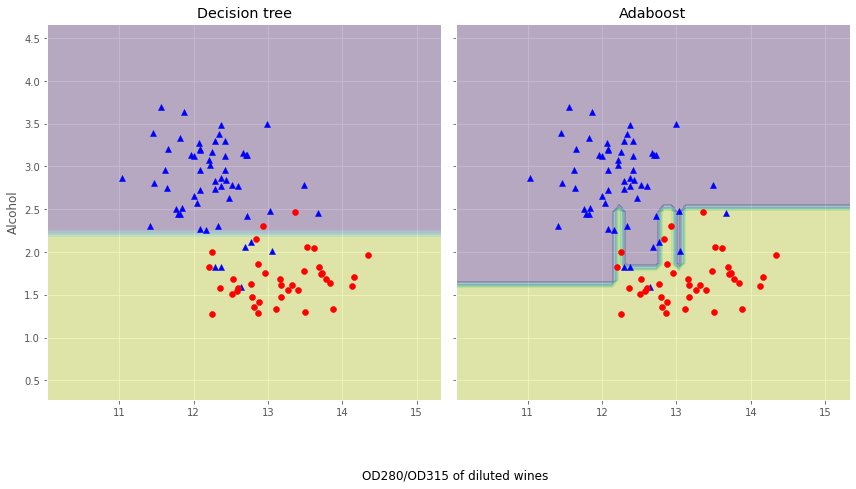

In [6]:
# 画出单层决策树与Adaboost的决策边界：
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=1, ncols=2,sharex='col',sharey='row',figsize=(12, 6))
for idx, clf, tt in zip([0, 1],[tree, ada],['Decision tree', 'Adaboost']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0],X_train[y_train==0, 1],c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0],X_train[y_train==1, 1],c='red', marker='o')
    axarr[idx].set_title(tt)
axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.tight_layout()
plt.text(0, -0.2,s='OD280/OD315 of diluted wines',ha='center',va='center',fontsize=12,transform=axarr[1].transAxes)
plt.show()